In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import transforms, datasets
from torchvision.datasets import ImageFolder
import torchvision.models as models
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import shutil
import math
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

In [14]:
# Configuration options
VERBOSE_OUTPUT = False  # Set to False to reduce output and avoid IOPub rate limit
SAVE_PLOTS = True      # Set to False to skip saving plots if not needed

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Path configurations
original_train_dir = Path(r"C:\Users\Aditya P J\Documents\Competition\Kaggle\Sheep Classification Images\train")
test_dir = Path(r"C:\Users\Aditya P J\Documents\Competition\Kaggle\Sheep Classification Images\test")
labels_file = Path(r"C:\Users\Aditya P J\Documents\Competition\Kaggle\Sheep Classification Images\train_labels.csv")
organized_data_dir = Path(r"C:\Users\Aditya P J\Documents\Competition\Kaggle\Sheep Classification Images\organized_data")


Using device: cpu


In [16]:
# Step 1: Organize training data by labels
if organized_data_dir.exists():
    print(f"Removing existing organized dataset directory: {organized_data_dir}")
    shutil.rmtree(organized_data_dir)
organized_data_dir.mkdir(parents=True, exist_ok=True)
print(f"Created new directory for organized dataset: {organized_data_dir}")

print(f"Reading labels from {labels_file}...")
df_labels = pd.read_csv(labels_file)
print(f"Dataset info: {len(df_labels)} labeled images")
print(f"Number of classes: {df_labels['label'].nunique()}")
print(f"Class distribution:")
print(df_labels['label'].value_counts().sort_index())

print(f"Organizing images from {original_train_dir} into {organized_data_dir}...")
copied_count = 0
missing_count = 0

for index, row in df_labels.iterrows():
    filename = row['filename']
    label = str(row['label'])  # Ensure label is a string for directory naming
    
    # Create label directory if it doesn't exist
    label_dir = organized_data_dir / label
    label_dir.mkdir(parents=True, exist_ok=True)
    
    # Source and destination paths
    src_image_path = original_train_dir / filename
    dst_image_path = label_dir / filename
    
    if src_image_path.exists():
        shutil.copy(src_image_path, dst_image_path)
        copied_count += 1
    else:
        print(f"Warning: Image '{filename}' not found in '{original_train_dir}'")
        missing_count += 1

print(f"Data organization complete. Copied {copied_count} images. Missing {missing_count} images")

Removing existing organized dataset directory: C:\Users\Aditya P J\Documents\Competition\Kaggle\Sheep Classification Images\organized_data
Created new directory for organized dataset: C:\Users\Aditya P J\Documents\Competition\Kaggle\Sheep Classification Images\organized_data
Reading labels from C:\Users\Aditya P J\Documents\Competition\Kaggle\Sheep Classification Images\train_labels.csv...
Dataset info: 682 labeled images
Number of classes: 7
Class distribution:
label
Barbari     35
Goat       107
Harri       62
Naeimi     255
Najdi       71
Roman       72
Sawakni     80
Name: count, dtype: int64
Organizing images from C:\Users\Aditya P J\Documents\Competition\Kaggle\Sheep Classification Images\train into C:\Users\Aditya P J\Documents\Competition\Kaggle\Sheep Classification Images\organized_data...
Data organization complete. Copied 682 images. Missing 0 images


In [20]:
# Step 2: Data preprocessing and augmentation
train_transform = transforms.Compose([
    transforms.Resize((384, 384)),  # EfficientNetV2 works well with 384x384
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.RandomResizedCrop(384, scale=(0.8, 1.0)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((384, 384)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((384, 384)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [22]:
from torchvision.datasets.folder import default_loader
from torch.utils.data import Dataset

class TestDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = Path(image_dir)
        self.image_files = sorted([f for f in self.image_dir.iterdir() if f.suffix.lower() in ['.jpg', '.jpeg', '.png']])
        self.transform = transform
        self.loader = default_loader

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = self.loader(img_path)
        if self.transform:
            image = self.transform(image)
        return image, img_path.name  # return filename too if needed

# Buat test dataset
test_dataset = TestDataset(test_dir, transform=test_transform)
print(f"Test samples: {len(test_dataset)}")


Test samples: 144


In [24]:
# Step 4: Create data loaders
batch_size = 16  # Adjust based on your GPU memory
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

# Step 5: Create EfficientNetV2 model
class EfficientNetV2Classifier(nn.Module):
    def __init__(self, num_classes):
        super(EfficientNetV2Classifier, self).__init__()
        # Load pre-trained EfficientNetV2-S
        self.backbone = models.efficientnet_v2_s(pretrained=True)
        
        # Freeze early layers for fine-tuning
        for param in list(self.backbone.parameters())[:-20]:  # Unfreeze last 20 parameters
            param.requires_grad = False
        
        # Modify classifier
        in_features = self.backbone.classifier[1].in_features
        self.backbone.classifier = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(in_features, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )
    
    def forward(self, x):
        return self.backbone(x)

In [26]:
# Step 6: Initialize model, loss, and optimizer
model = EfficientNetV2Classifier(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

print(f"Model created with {num_classes} classes")
print(f"Total parameters: {sum(p.numel() for p in model.parameters())}")
print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")

# Step 7: Training function
def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    progress_bar = tqdm(train_loader, desc='Training', disable=not VERBOSE_OUTPUT)
    for inputs, labels in progress_bar:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        # Update progress less frequently to avoid IOPub rate limit
        if (len(progress_bar) % 10 == 0) or (len(progress_bar) == len(train_loader)):
            # Update progress less frequently
            if (len(progress_bar) % 10 == 0) or (len(progress_bar) == len(val_loader)):
                progress_bar.set_postfix({
                    'Loss': f'{running_loss/len(progress_bar):.4f}',
                    'Acc': f'{100*correct/total:.2f}%'
                })
    
    return running_loss / len(train_loader), 100 * correct / total


Model created with 7 classes
Total parameters: 20836951
Trainable parameters: 1995335


In [28]:
# Step 8: Validation function
def validate_epoch(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        progress_bar = tqdm(val_loader, desc='Validation', disable=not VERBOSE_OUTPUT)
        for inputs, labels in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            progress_bar.set_postfix({
                'Loss': f'{running_loss/len(progress_bar):.4f}',
                'Acc': f'{100*correct/total:.2f}%'
            })
    
    return running_loss / len(val_loader), 100 * correct / total

Starting training...

Epoch 1/20
--------------------------------------------------
Train Loss: 1.2127, Train Acc: 57.74%
Val Loss: 0.5975, Val Acc: 81.86%
New best model saved with validation accuracy: 81.86%

Epoch 2/20
--------------------------------------------------
Train Loss: 0.6063, Train Acc: 80.96%
Val Loss: 0.5353, Val Acc: 80.88%

Epoch 3/20
--------------------------------------------------
Train Loss: 0.3921, Train Acc: 87.03%
Val Loss: 0.5134, Val Acc: 82.35%
New best model saved with validation accuracy: 82.35%

Epoch 4/20
--------------------------------------------------
Train Loss: 0.3975, Train Acc: 88.08%
Val Loss: 0.6506, Val Acc: 81.37%

Epoch 5/20
--------------------------------------------------
Train Loss: 0.3404, Train Acc: 87.24%
Val Loss: 0.3254, Val Acc: 88.24%
New best model saved with validation accuracy: 88.24%

Epoch 6/20
--------------------------------------------------
Train Loss: 0.2903, Train Acc: 89.96%
Val Loss: 0.3527, Val Acc: 88.24%

Epoch 

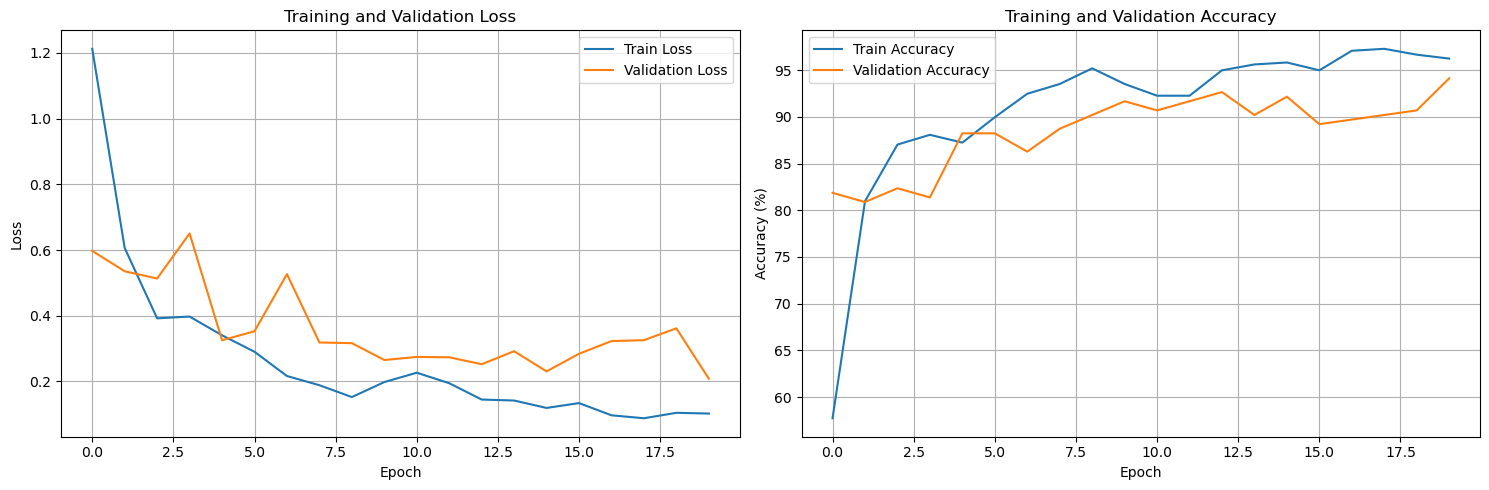

In [30]:
# Step 9: Training loop
num_epochs = 20
best_val_acc = 0.0
train_losses, train_accs = [], []
val_losses, val_accs = [], []

print("Starting training...")
for epoch in range(num_epochs):
    print(f'\nEpoch {epoch+1}/{num_epochs}')
    print('-' * 50)
    
    # Train
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    
    # Validate
    val_loss, val_acc = validate_epoch(model, val_loader, criterion, device)
    
    # Update learning rate
    scheduler.step(val_loss)
    
    # Save metrics
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    
    print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
    print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
    
    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'best_val_acc': best_val_acc,
            'class_names': class_names
        }, 'best_goat_classifier.pth')
        print(f'New best model saved with validation accuracy: {best_val_acc:.2f}%')

print(f'\nTraining completed! Best validation accuracy: {best_val_acc:.2f}%')

# Step 10: Plot training history
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(val_accs, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
plt.show()

In [41]:
# ===== Step 11: Load best model and evaluate on test set =====
print("\nLoading best model for test evaluation...")
checkpoint = torch.load('best_goat_classifier.pth')
model.load_state_dict(checkpoint['model_state_dict'])

model.eval()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

test_correct = 0
test_total = 0
all_preds = []
all_labels = []

with torch.no_grad():
    progress_bar = tqdm(test_loader, desc='Testing')
    for inputs, labels in progress_bar:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)

        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        progress_bar.set_postfix({
            'Acc': f'{100 * test_correct / test_total:.2f}%'
        })

test_accuracy = 100 * test_correct / test_total
print(f'\nTest Accuracy: {test_accuracy:.2f}%')

# ===== Step 12: Classification report and confusion matrix =====
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))

plt.figure(figsize=(12, 10))
cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()


Loading best model for test evaluation...


Testing:   0%|                                                                                   | 0/9 [00:10<?, ?it/s]


RuntimeError: DataLoader worker (pid(s) 26484, 13208, 16108, 18604) exited unexpectedly

In [ ]:
# Step 13: Prediction function for new images
def predict_image(model, image_path, transform, class_names, device):
    """Predict class for a single image"""
    from PIL import Image

    model.eval()
    try:
        image = Image.open(image_path).convert('RGB')
    except Exception as e:
        print(f"[ERROR] Cannot open image: {image_path} - {e}")
        return None, None, None

    image_tensor = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(image_tensor)
        probabilities = torch.nn.functional.softmax(outputs[0], dim=0)
        _, predicted = torch.max(outputs, 1)

    predicted_class = class_names[predicted.item()]
    confidence = probabilities[predicted.item()].item()

    return predicted_class, confidence, probabilities

# Example usage
print("\nModel training and evaluation completed!")
print("To predict on a new image, use:")
print("predicted_class, confidence, probs = predict_image(model, 'path_to_image.jpg', test_transform, class_names, device)")


In [ ]:

# Step 14: Create submission file for test images
from PIL import Image, UnidentifiedImageError
import os

# Setup paths and directories
HOME = Path.home()
test_image_dir = Path(r"C:\Users\Aditya P J\Documents\Competition\Kaggle\Sheep Classification Images\test")
output_dir = Path('submission_output')
output_dir.mkdir(parents=True, exist_ok=True)
submission_file = output_dir / 'submission.csv'

print(f"\nCreating submission file...")
print(f"Test directory: {test_image_dir}")
print(f"Output directory: {output_dir}")

# Get all test image files
test_image_files = sorted([f for f in os.listdir(test_image_dir) 
                          if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
print(f"Found {len(test_image_files)} test images")

predictions = []

# Ensure model is in evaluation mode and on correct device
model.eval()
model.to(device)

print("Making predictions on test images...")
for i, image_file in enumerate(tqdm(test_image_files, desc="Processing test images")):
    image_path = test_image_dir / image_file
    try:
        # Load and preprocess image
        image = Image.open(image_path).convert('RGB')
        
        # Apply the same transformations as validation/test
        inputs = test_transform(image).unsqueeze(0).to(device)
        
        with torch.no_grad():  # Disable gradient calculations for inference
            outputs = model(inputs)
        
        # Get predicted class
        _, predicted_class_idx = torch.max(outputs, 1)
        predicted_label = class_names[predicted_class_idx.item()]
        
        predictions.append({
            'filename': image_file, 
            'label': predicted_label
        })
        
    except UnidentifiedImageError:
        print(f"Skipping file {image_file} as it could not be identified as an image.")
    except Exception as e:
        print(f"Error processing file {image_file}: {e}")

# Create DataFrame and save to CSV
submission_df = pd.DataFrame(predictions)
submission_df.to_csv(submission_file, index=False)

print(f"\nSubmission file created at {submission_file}")
print(f"Total predictions made: {len(predictions)}")
print("\nSubmission file preview:")
print(submission_df.head(10))

# Display prediction statistics
if len(predictions) > 0:
    label_counts = submission_df['label'].value_counts()
    print(f"\nPrediction distribution:")
    for label, count in label_counts.items():
        print(f"  {label}: {count} images")

# Step 15: Save final model info
model_info = {
    'model_architecture': 'EfficientNetV2-S',
    'num_classes': num_classes,
    'class_names': class_names,
    'best_val_accuracy': best_val_acc,
    'test_accuracy': test_accuracy,
    'total_train_samples': len(train_indices),
    'total_val_samples': len(val_indices),
    'total_test_samples': len(test_dataset)
}

print("\nModel Information:")
for key, value in model_info.items():
    print(f"{key}: {value}")

# Save model info to file
import json
with open('model_info.json', 'w') as f:
    json.dump(model_info, f, indent=2)